In [79]:
import warnings
warnings.filterwarnings("ignore")

In [80]:
import pandas as pd
import numpy as np
import math
import sklearn
import itertools

from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors

In [81]:
Data = pd.read_csv('House_Price_Regression.csv')

Data = Data.loc[:, ['latitude', 'longitude', 'no_of_bathrooms', 'no_of_bedrooms', 'price', 'size_in_m_2', 'balcony_recode', 'private_garden_recode', 'quality_recode']]

Data.head()

,latitude,longitude,no_of_bathrooms,no_of_bedrooms,price,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
0,25.113208,55.138932,2,1,2700000,100.242337,1.0,0.0,2.0
1,25.106809,55.151201,2,2,2850000,146.972546,1.0,0.0,2.0
2,25.063302,55.137728,5,3,1150000,181.253753,1.0,0.0,2.0
3,25.227295,55.341761,3,2,2850000,187.664060,1.0,0.0,1.0
4,25.114275,55.139764,1,0,1729200,47.101821,0.0,0.0,2.0


## Algoritmos de validación

In [170]:
def simple_validation_random(D, k, response, random_seed, metric, model):

    # D --> have to be a pandas data frame.

    # k --> is the proportion of observation of D that define D_train.

    # response --> have to be a string with the name of the response variable.

    # random_seed --> seed to replicate the random process

    N = len(D)

    D_train = D.sample(frac=k, replace=False, random_state=random_seed)

    D_test = D.drop( D_train.index , )

    X_train = D_train.loc[: , D_train.columns != response]
    Y_train = D_train.loc[: , response]

    X_test = D_test.loc[: , D_test.columns != response]
    Y_test = D_test.loc[: , response]

############################################################################

    # Training the model wit train sample

    model.fit(X_train, Y_train)

    # Making predictions with test sample

    Y_predict_test = model.predict( X_test ) 

####################################################################

 # Computing the test metric

    if metric == 'ECM' :  
        
        ECM_test = np.mean( (Y_predict_test - Y_test)**2 )

        return ECM_test

    elif metric == 'TAC' :  
        
        TA_test = np.mean( (Y_predict_test == Y_test) )

        return TA_test

In [169]:
def repeated_random_simple_validation(D, k, B, response, random_seed, metric, model):

    # D --> have to be a pandas data frame.

    # k --> is the proportion of observation of D that define D_train.

    # B --> number of replications of the random simple validation algorithm

    # response --> have to be a string with the name of the response variable.

    # random_seed --> seed to replicate the random process


    np.random.seed(random_seed)

    ECM_test_list , TA_test_list = [ ] , [ ]

    seed_array = np.random.randint(9999999, size=(B))


    if metric == 'ECM':

        for b in range(0,B) :

            ECM_test_list.append( simple_validation_random(D, k, response, random_seed=seed_array[b], metric=metric, model=model) )


        ECM_test = np.mean(ECM_test_list)    

        return ECM_test 


    elif metric == 'TAC':

        for b in range(0,B) :

            TA_test_list.append( simple_validation_random(D, k, response, random_seed=seed_array[b], metric=metric, model=model) )


        TA_test = np.mean(TA_test_list)    

        return TA_test 

In [84]:
def repeated_K_Fold_CV(D, B, K, response, random_seed, metric, model):


    ECM_Repeated_K_Folds_vector , TA_Repeated_K_Folds_vector = [] , []

    np.random.seed(random_seed)


    for b in range(0, B):

        sample = resample(range(0, len(D)), n_samples=len(D), replace=False)

        df_sample = pd.DataFrame({'index': range(0,len(D)) , 'sample':sample})

        
        Q = []

        
        for q in np.arange(0 , 1 + 1/K , 1/K):

            Q.append( np.quantile( range(0, len(D)) , q ).round(0) )



        ECM_K_FOLDS_vector , TA_K_FOLDS_vector = [] , []

        for j in range(0, len(Q)-1):

            X_test = D.loc[df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] , D.columns != response ] 
            Y_test = D.loc[df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] , D.columns == response ]

            X_train = D.loc[ : , D.columns != response ].drop(df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] )
            Y_train = D.loc[ : ,  D.columns == response ].drop(df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'])      

            Y_test = Y_test.to_numpy()

        #######################################################################
            
            # Training the model wit train sample

            model.fit(X_train, Y_train)

            # Making predictions with test sample

            Y_predict_test = model.predict( X_test )   

        #######################################################################

            if metric == 'ECM' :  ECM_K_FOLDS_vector.append( np.mean( ( Y_predict_test - Y_test )**2 ) )

            elif metric == 'TAC' :  TA_K_FOLDS_vector.append( np.mean( ( Y_predict_test == Y_test ) ) )

    
    #######################################################################
    
        if metric == 'ECM' : ECM_Repeated_K_Folds_vector.append( np.mean(ECM_K_FOLDS_vector) )

        elif metric == 'TAC' : TA_Repeated_K_Folds_vector.append( np.mean(TA_K_FOLDS_vector) )

##########################################################################################################################

    if metric == 'ECM' :
        
        ECM_Repeated_K_Folds = np.mean(ECM_Repeated_K_Folds_vector)

        return  ECM_Repeated_K_Folds
        

    elif metric == 'TAC' :
        
        TA_Repeated_K_Folds = np.mean(TA_Repeated_K_Folds_vector)

        return  TA_Repeated_K_Folds
    
    

## Grid search 

In [85]:
def Grid_search(Data, Search_Space, response, model, validation, metric, B, k, K, random_seed_2, random_search, random_seed_1, random_samples):

   Grid_Search_Metric_list = []

   hyperparameter_combinations = list( itertools.product(Search_Space[0], Search_Space[1]) )

   if random_search == True : 
      
      hyperparameter_combinations = resample(hyperparameter_combinations, n_samples=random_samples, replace=False, random_state=random_seed_1)
   
   else : 
      
      pass


   if model == 'knn_regression' :

      if validation == 'repeated_random_simple_validation' :

         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_regression = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0] ,  metric=h[1]) 

            # Applying a validation algorithm on the model  

            Grid_Search_Metric_list.append( repeated_random_simple_validation(Data, k, B, response, random_seed_2, metric, model=knn_regression) )

      #######################################################################   
          
      if validation == 'repeated_K_Fold_CV' :
            
         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_regression = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0], metric=h[1]) 

            # Applying a validation algorithm on the model  

            Grid_Search_Metric_list.append( repeated_K_Fold_CV(Data, B, K, response, random_seed_2, metric, model=knn_regression) )


####################################################################################

   if model == 'knn_classification' :

      if validation == 'repeated_random_simple_validation' :

         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_classification = sklearn.neighbors.KNeighborsClassifier(n_neighbors=h[0],  metric=h[1]) 

            # Applying a validation algorithm on the model  

            Grid_Search_Metric_list.append( repeated_random_simple_validation(Data, k, B, response, random_seed_2, metric, model=knn_classification) )

            #######################################################################   
          
      if validation == 'repeated_K_Fold_CV' :
            
         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_classification = sklearn.neighbors.KNeighborsClassifier(n_neighbors=h[0] ,  metric=h[1]) 

            # Applying a validation algorithm on the model  

            Grid_Search_Metric_list.append( repeated_K_Fold_CV(Data, B, K, response, random_seed_2, metric, model=knn_classification) )


####################################################################################

   df = pd.DataFrame({'(k , distance)': hyperparameter_combinations, metric: Grid_Search_Metric_list})

   if metric == 'ECM' :

      df = df.sort_values(by=metric, ascending=True)

   elif metric == 'TAC' :

      df = df.sort_values(by=metric, ascending=False)


   return df

In [88]:
Grid_search_1 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 56.8seg

In [89]:
Grid_search_1

,"(k , distance)",ECM
57,"(15, cosine)",2.064764e+12
61,"(16, cosine)",2.067621e+12
65,"(17, cosine)",2.079897e+12
53,"(14, cosine)",2.086479e+12
58,"(15, cityblock)",2.088501e+12
...,...,...
395,"(99, manhattan)",3.470547e+12
392,"(99, euclidean)",3.471920e+12
1,"(1, cosine)",3.646170e+12
2,"(1, cityblock)",3.677001e+12


In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

In [200]:
sns.set(rc={'figure.figsize':(9 , 6)})

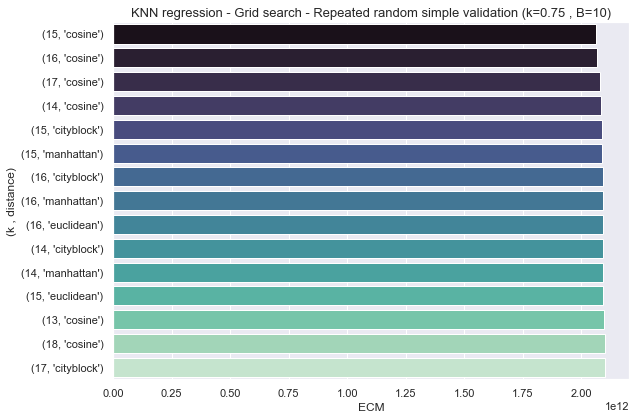

In [207]:
fig, ax = plt.subplots()

p1 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_1.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=10)", fontsize=13)

plt.tight_layout()

fig.savefig('p1.jpg', format='jpg', dpi=1200)

In [173]:
Grid_search_1_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [174]:
Grid_search_1_2

,"(k , distance)",TAC
210,"(53, cityblock)",0.595168
211,"(53, manhattan)",0.595168
301,"(76, cosine)",0.594958
293,"(74, cosine)",0.594958
297,"(75, cosine)",0.594748
...,...,...
12,"(4, euclidean)",0.483403
5,"(2, cosine)",0.429622
7,"(2, manhattan)",0.411555
6,"(2, cityblock)",0.411555


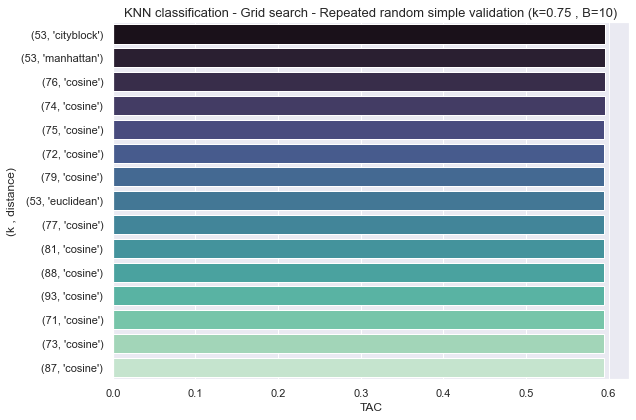

In [205]:
fig, ax = plt.subplots()

p2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_1_2.iloc[0:15 , :], palette='mako')

plt.title("KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=10)", fontsize=13)

plt.tight_layout()

fig.savefig('p2.jpg', format='jpg', dpi=1200)

In [90]:
Grid_search_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 1.57seg

In [190]:
Grid_search_2

,"(k , distance)",ECM
61,"(16, cosine)",2.079239e+12
57,"(15, cosine)",2.084669e+12
65,"(17, cosine)",2.090697e+12
53,"(14, cosine)",2.108925e+12
73,"(19, cosine)",2.109291e+12
...,...,...
391,"(98, manhattan)",3.700114e+12
388,"(98, euclidean)",3.703232e+12
394,"(99, cityblock)",3.710922e+12
395,"(99, manhattan)",3.710922e+12


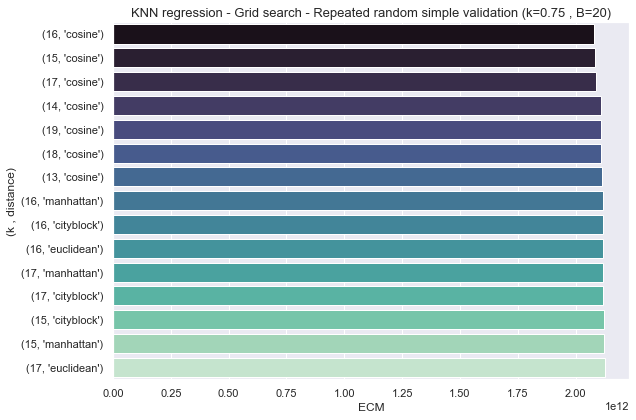

In [208]:
fig, ax = plt.subplots()

p3 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_2.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p3.jpg', format='jpg', dpi=1200)

In [193]:
Grid_search_2_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [194]:
Grid_search_2_2

,"(k , distance)",TAC
369,"(93, cosine)",0.597689
349,"(88, cosine)",0.597689
321,"(81, cosine)",0.597689
345,"(87, cosine)",0.597689
325,"(82, cosine)",0.597584
...,...,...
12,"(4, euclidean)",0.478782
5,"(2, cosine)",0.431092
7,"(2, manhattan)",0.416071
6,"(2, cityblock)",0.416071


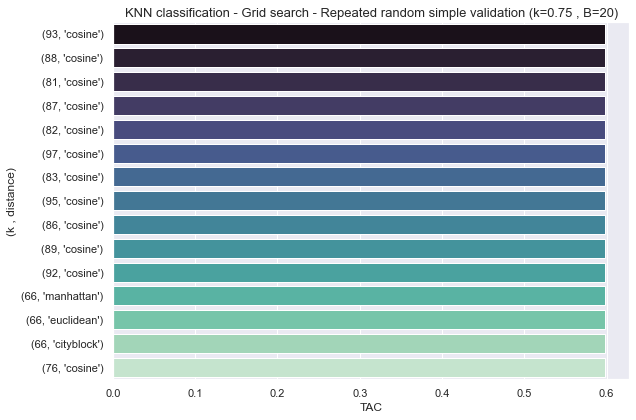

In [210]:
fig, ax = plt.subplots()

p4 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_2_2.iloc[0:15 , :], palette='mako')

plt.title("KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p4.jpg', format='jpg', dpi=1200)

In [92]:
Grid_search_3 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 5.3min

In [93]:
Grid_search_3

,"(k , distance)",ECM
61,"(16, cosine)",2.079239e+12
57,"(15, cosine)",2.084669e+12
65,"(17, cosine)",2.090697e+12
53,"(14, cosine)",2.108925e+12
73,"(19, cosine)",2.109291e+12
...,...,...
791,"(198, manhattan)",4.670408e+12
788,"(198, euclidean)",4.672717e+12
794,"(199, cityblock)",4.676174e+12
795,"(199, manhattan)",4.676174e+12


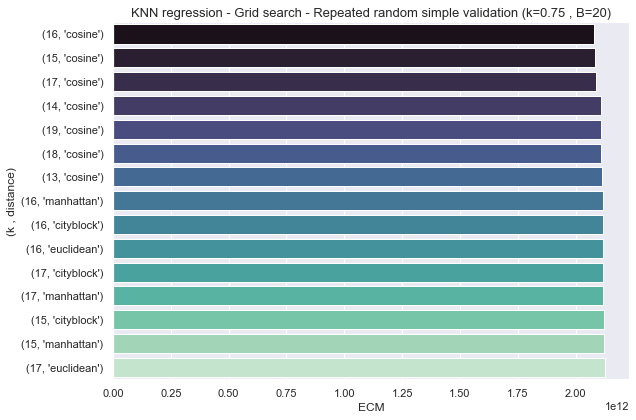

In [211]:
fig, ax = plt.subplots()

p5 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_3.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p5.jpg', format='jpg', dpi=1200)

In [215]:
Grid_search_3_2 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_3_2

In [ ]:
fig, ax = plt.subplots()

p5_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_3_2.iloc[0:15 , :], palette='mako')

plt.title("KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p5_2.jpg', format='jpg', dpi=1200)

In [94]:
Grid_search_4 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=20, k=0.75, K='no', random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

Time: 1.2min

In [95]:
Grid_search_4

,"(k , distance)",ECM
23,"(15, cosine)",2.084669e+12
190,"(15, manhattan)",2.124952e+12
165,"(17, euclidean)",2.126173e+12
47,"(19, cityblock)",2.128057e+12
68,"(19, manhattan)",2.128057e+12
...,...,...
128,"(196, cityblock)",4.657349e+12
199,"(196, euclidean)",4.659289e+12
17,"(198, cityblock)",4.670408e+12
142,"(198, manhattan)",4.670408e+12


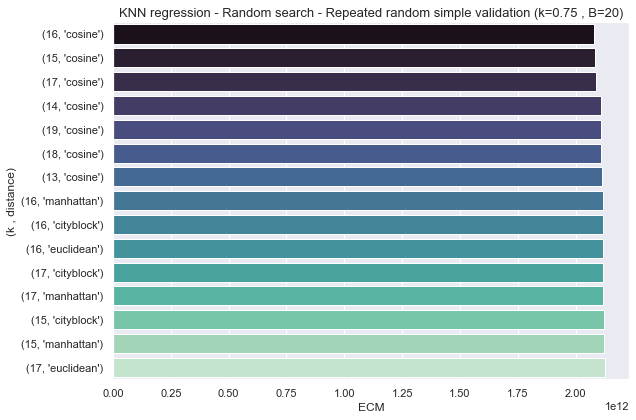

In [212]:
fig, ax = plt.subplots()

p6 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_4.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Random search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p6.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_4_2 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=20, k=0.75, K='no', random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_4_2

In [ ]:
fig, ax = plt.subplots()

p6 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_4_2.iloc[0:15 , :], palette='mako')

plt.title("KNN classification - Random search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p6.jpg', format='jpg', dpi=1200)

In [96]:
Grid_search_5 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=5, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 4.37 min

In [97]:
Grid_search_5

,"(k , distance)",ECM
69,"(18, cosine)",2.213103e+12
73,"(19, cosine)",2.213636e+12
57,"(15, cosine)",2.215151e+12
61,"(16, cosine)",2.221992e+12
65,"(17, cosine)",2.222929e+12
...,...,...
391,"(98, manhattan)",4.068432e+12
388,"(98, euclidean)",4.072752e+12
394,"(99, cityblock)",4.087051e+12
395,"(99, manhattan)",4.087051e+12


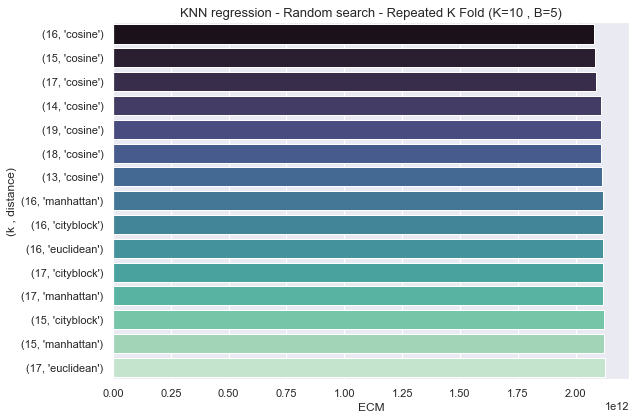

In [213]:
fig, ax = plt.subplots()

p7 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_5.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=5)", fontsize=13)

plt.tight_layout()

fig.savefig('p7.jpg', format='jpg', dpi=1200)

In [98]:
Grid_search_6 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=15, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 14.35min

In [100]:
Grid_search_6

,"(k , distance)",ECM
65,"(17, cosine)",2.212144e+12
69,"(18, cosine)",2.214874e+12
61,"(16, cosine)",2.215972e+12
73,"(19, cosine)",2.220315e+12
57,"(15, cosine)",2.226790e+12
...,...,...
390,"(98, cityblock)",4.082009e+12
388,"(98, euclidean)",4.086456e+12
394,"(99, cityblock)",4.101063e+12
395,"(99, manhattan)",4.101063e+12


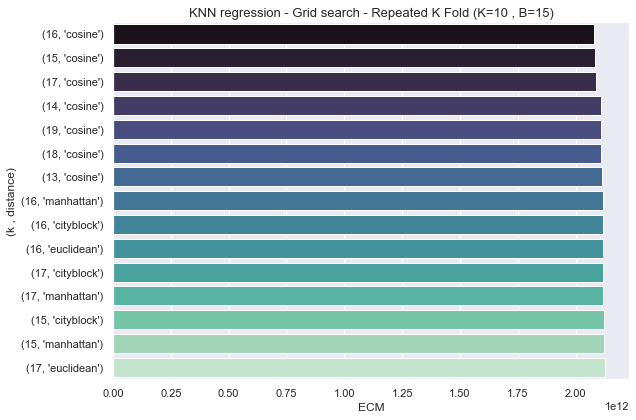

In [214]:
fig, ax = plt.subplots()

p8 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_6.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Grid search - Repeated K Fold (K=10 , B=15)", fontsize=13)

plt.tight_layout()

fig.savefig('p8.jpg', format='jpg', dpi=1200)

In [101]:
Grid_search_7 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=15, k='no', K=10, random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

Time: 7.29 mins

In [102]:
Grid_search_7

,"(k , distance)",ECM
164,"(16, cosine)",2.215972e+12
138,"(14, cosine)",2.241301e+12
196,"(13, cosine)",2.245269e+12
125,"(8, cosine)",2.246148e+12
50,"(7, cityblock)",2.249594e+12
...,...,...
36,"(97, euclidean)",4.069186e+12
53,"(98, manhattan)",4.082009e+12
134,"(99, cityblock)",4.101063e+12
130,"(99, manhattan)",4.101063e+12


In [ ]:
fig, ax = plt.subplots()

p9 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_7.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=15)", fontsize=13)

plt.tight_layout()

fig.savefig('p9.jpg', format='jpg', dpi=1200)

In [103]:
Grid_search_8 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=5, k='no', K=10, random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

Time: 2.16min

In [104]:
Grid_search_8

,"(k , distance)",ECM
164,"(16, cosine)",2.221992e+12
138,"(14, cosine)",2.233684e+12
196,"(13, cosine)",2.242026e+12
106,"(14, manhattan)",2.251908e+12
6,"(14, cityblock)",2.251908e+12
...,...,...
36,"(97, euclidean)",4.056875e+12
53,"(98, manhattan)",4.068432e+12
134,"(99, cityblock)",4.087051e+12
130,"(99, manhattan)",4.087051e+12


In [ ]:
fig, ax = plt.subplots()

p10 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_8.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=5)", fontsize=13)

plt.tight_layout()

fig.savefig('p10.jpg', format='jpg', dpi=1200)

In [121]:
Grid_search_9 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=1, k='no', K=10, random_search=False, random_samples=200, random_seed_1=123, random_seed_2=123)

In [122]:
Grid_search_9

,"(k , distance)",ECM
30,"(8, cityblock)",2.149765e+12
31,"(8, manhattan)",2.149765e+12
28,"(8, euclidean)",2.167357e+12
69,"(18, cosine)",2.172008e+12
33,"(9, cosine)",2.179763e+12
...,...,...
391,"(98, manhattan)",4.028750e+12
388,"(98, euclidean)",4.032013e+12
394,"(99, cityblock)",4.048032e+12
395,"(99, manhattan)",4.048032e+12


In [ ]:
fig, ax = plt.subplots()

p11 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_9.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=1)", fontsize=13)

plt.tight_layout()

fig.savefig('p11.jpg', format='jpg', dpi=1200)

# Ajuste de hiperparametros con `Sklearn`

In [105]:
import numpy as np

In [106]:
from sklearn.model_selection import GridSearchCV

In [107]:
knn_regression = sklearn.neighbors.KNeighborsRegressor( )

In [144]:
grid_search = GridSearchCV(estimator = knn_regression, param_grid = {'n_neighbors': range(1,200), 'metric': ['euclidean','cosine','cityblock','manhattan']}, cv = 10, scoring='neg_mean_squared_error')

In [145]:
Y = Data.loc[:,'price']

X = Data.loc[:, Data.columns != 'price']

In [146]:
grid_search.fit(X,Y)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'cosine', 'cityblock',
                                    'manhattan'],
                         'n_neighbors': range(1, 200)},
             scoring='neg_mean_squared_error')

In [147]:
grid_search.best_estimator_

KNeighborsRegressor(metric='cosine', n_neighbors=17)

In [148]:
grid_search.best_params_

{'metric': 'cosine', 'n_neighbors': 17}

In [149]:
grid_search.best_score_

-2278523570223.8994

In [155]:
df_grid_search_sklearn = pd.DataFrame({'k': grid_search.cv_results_['param_n_neighbors'], 'distance': grid_search.cv_results_['param_metric'] , 'ECM': - grid_search.cv_results_['mean_test_score']})


In [158]:
df_grid_search_sklearn.sort_values(by='ECM', ascending=True)

,k,distance,ECM
215,17,cosine,2.278524e+12
209,11,cosine,2.287579e+12
214,16,cosine,2.300468e+12
216,18,cosine,2.305225e+12
210,12,cosine,2.308334e+12
...,...,...,...
794,198,manhattan,5.264590e+12
197,198,euclidean,5.266036e+12
198,199,euclidean,5.272047e+12
596,199,cityblock,5.273960e+12


In [127]:
from sklearn.model_selection import RandomizedSearchCV

In [126]:
from scipy.stats import uniform

In [135]:
uniform(loc=2, )

In [163]:
random_search = RandomizedSearchCV(estimator = knn_regression, param_distributions = {'n_neighbors': range(1,200), 'metric': ['euclidean','cosine','cityblock','manhattan']}, cv = 10, n_iter=100, random_state=123, scoring='neg_mean_squared_error')

In [164]:
random_search.fit(X,Y)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(), n_iter=100,
                   param_distributions={'metric': ['euclidean', 'cosine',
                                                   'cityblock', 'manhattan'],
                                        'n_neighbors': range(1, 200)},
                   random_state=123, scoring='neg_mean_squared_error')

In [165]:
df_random_search_sklearn = pd.DataFrame({'k': random_search.cv_results_['param_n_neighbors'], 'distance': random_search.cv_results_['param_metric'] , 'ECM': - random_search.cv_results_['mean_test_score']})

In [166]:
df_random_search_sklearn.sort_values(by='ECM', ascending=True)

,k,distance,ECM
18,11,cosine,2.287579e+12
38,11,manhattan,2.321534e+12
91,14,euclidean,2.334281e+12
84,19,cosine,2.337300e+12
78,12,euclidean,2.339571e+12
...,...,...,...
60,189,cityblock,5.180324e+12
43,189,euclidean,5.182189e+12
46,190,cityblock,5.187852e+12
17,194,manhattan,5.227831e+12


## Grid search como metodo de optimizacion de funciones matematicas

In [11]:
values = []

for x in range(-99999 , 99999) :

    values.append( x**2 )


In [12]:
df = pd.DataFrame({'x':range(-99999 , 99999)  , 'f(x)':values})

In [13]:
df.sort_values(by='f(x)')

,x,f(x)
99999,0,0
99998,-1,1
100000,1,1
100001,2,4
99997,-2,4
...,...,...
2,-99997,9999400009
199996,99997,9999400009
199997,99998,9999600004
1,-99998,9999600004


In [14]:
values , Search_Space_list = [] , []

Search_Space_1 = range(-100 , 100)

Search_Space_2 = range(-100 , 100)

hyperparameter_combinations = list( itertools.product(Search_Space_1, Search_Space_2) )

for x in hyperparameter_combinations :

    Search_Space_list.append(x)

    values.append( x[0]**2 + x[1]**2)


In [15]:
df = pd.DataFrame({'(x_1,x_2)':Search_Space_list , 'f(x_1,x_2)':values})

In [16]:
df.sort_values(by='f(x_1,x_2)', ascending=True )

,"(x_1,x_2)","f(x_1,x_2)"
20100,"(0, 0)",0
20101,"(0, 1)",1
20300,"(1, 0)",1
20099,"(0, -1)",1
19900,"(-1, 0)",1
...,...,...
39800,"(99, -100)",19801
200,"(-99, -100)",19801
199,"(-100, 99)",19801
1,"(-100, -99)",19801
